In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, random_split
import torch.nn.functional as F
import torch.optim as optim
import os
from PIL import Image

In [2]:
# Custom dataset
# Data is organized as:
#archive/
#   data/
#       dogs/
#           img1.jpg
#           ...
#       wolves/
#           img1.jpg
#           ...       

class DogsAndWolvesDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = ['dogs', 'wolves']
        self.img_paths = []
        self.labels = []

        for idx, cls in enumerate(self.classes):
            class_dir = os.path.join(root_dir, cls)
            for img_name in os.listdir(class_dir):
                self.img_paths.append(os.path.join(class_dir, img_name))
                self.labels.append(idx) # Label 0 for dog and 1 for wolf

    def __len__(self):
        return len(self.img_paths)
    
    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        image = Image.open(img_path).convert("RGB")
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)
        
        return image, label
    
class CNN(nn.Module):
    def __init__(self, in_chanel=3, num_classes=2):
        super(CNN, self).__init__()
        # Convolution layers (4 conv layers with max pooling after each and batch normalization after each conv layer)
        self.conv1 = nn.Conv2d(in_channels=in_chanel, out_channels=16, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.bn1 = nn.BatchNorm2d(16)
        self.pool = nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)) # pooling with kernel size 2 and stride 2 reduces each dimension by factor 2
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.bn4 = nn.BatchNorm2d(128)
        
        # Fully connected layers with dropout (probability of 0.5)
        self.dropout = nn.Dropout(p=0.25)
        self.fc1 = nn.Linear(128*14*14, 1024) # 14x14 is the size of the tensor after 4 max pooling layers and 128 is the number of output channels from the last conv layer
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 128)
        self.fc4 = nn.Linear(128, 2) # Output layer for binary classification with softmax

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        x = x.view(-1, 128*14*14) # Flatten the tensor before FC layer
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

class EarlyStopping:
    def __init__(self, patience=5, verbose=False, delta=0, path='checkpoint.pt'):
        self.patience = patience # How long to wait after last time validation loss improved
        self.verbose = verbose # If True, prints a message for each validation loss improvement
        self.counter = 0 # Counter tracks how many epochs have passed since last improvement
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.inf
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):
        score = -val_loss # Class is designed to work with higher is better principle, but since lower validation loss is better, we need to negate it

        # First epoch check
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        
        # Improvement check
        elif score < self.best_score + self.delta: # If score is not better than best_score + delta
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        
        # Improvement found
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0
        
    def save_checkpoint(self, val_loss, model):
        # Save model if validation loss has decreased
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [3]:
# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [4]:
# Model testing
test_model = CNN()
input_tensor = torch.randn(1, 3, 224, 224)  # Batch size 1, 3 channels, 224x224 image
output = test_model(input_tensor)
print(output.shape) 

torch.Size([1, 2])


In [5]:
# Calculate the mean and std of images for data normalization
def mean_std(dataset):
    mean = torch.zeros(3)
    std = torch.zeros(3)

    for img, _ in dataset:
        mean += img.mean([1,2]) 
        std += img.mean([1,2])
    mean /= len(dataset)
    std /= len(dataset)

    return mean, std

path = 'archive/data'

temp_transform = transforms.Compose([
    transforms.ToTensor(),
])

temp_data = DogsAndWolvesDataset(path, temp_transform)

mean_calc, std_calc = mean_std(temp_data)
print("Mean: ", mean_calc)
print("Standart diviation: ", std_calc)

Mean:  tensor([0.4633, 0.4484, 0.3953])
Standart diviation:  tensor([0.4633, 0.4484, 0.3953])


In [6]:
# Define transformations with augmentation
transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.RandomCrop((224,224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),
    transforms.RandomGrayscale(p=0.2),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean_calc.tolist(), std=std_calc.tolist())
])

dataset = DogsAndWolvesDataset(path, transform=transform)

In [7]:
# Parameters
batch_size = 16
num_epochs = 50
learning_rate = 0.001

# Split the dataset into train validate and test
train_size = int(0.8*len(dataset))
val_size = int(0.1*len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)

In [15]:
# Define the model, loss function and optimizer
model = CNN().to(device)

# Select criterion and optimizer
criterion = nn.CrossEntropyLoss() # Cross entropy loss for classification
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5) # Adam optimizer with L2 regularization

# Learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Early stopping
early_stopping = EarlyStopping(patience=5, verbose=True)

In [16]:
training_loss = []
validation_loss = []
val_accuracy = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0

    # loop through all the batches in the training dataset
    for i, (img, label) in enumerate(train_loader):
        # move the data to device
        img = img.to(device)
        label = label.to(device)

        # forward pass
        outputs = model(img)
        loss = criterion(outputs, label)

        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Track the training loss
        running_loss += loss.item()

    # Avrage training loss for each epoch
    mean_train_loss = running_loss/len(train_loader)
    training_loss.append(mean_train_loss)
    
    # Validation at the end of each epoch
    with torch.no_grad():
        model.eval()
        correct = 0
        total = 0
        all_val_loss = [] 
        for img, label in val_loader:
            img = img.to(device)
            label = label.to(device)

            outputs = model(img)
            loss = criterion(outputs, label)

            _, predicted = torch.max(outputs.data, 1)
            total += label.size(0)
            correct += (predicted == label).sum().item()
            all_val_loss.append(loss.item()) 

        # Print the loss and accuracy at the end of each epoch
        mean_val_loss = sum(all_val_loss)/len(all_val_loss)
        validation_loss.append(mean_val_loss)
        accuracy = 100 * correct / total
        val_accuracy.append(accuracy)

        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}, Validation Loss: {mean_val_loss:.4f}, Accuracy: {accuracy:.2f}%')

        # Early stopping
        early_stopping(mean_val_loss, model)

        if early_stopping.early_stop:
            print("Early stopping")
            break

    # Step the scheduler
    scheduler.step() 

# Save the final model weights
torch.save(model.state_dict(), 'final_model_weights.pth')
print("Model weights saved successfully!")

Epoch 1/50, Loss: 0.8319, Validation Loss: 0.7096, Accuracy: 54.50%
Validation loss decreased (inf --> 0.709553).  Saving model ...
Epoch 2/50, Loss: 0.6624, Validation Loss: 0.6617, Accuracy: 55.00%
Validation loss decreased (0.709553 --> 0.661730).  Saving model ...
Epoch 3/50, Loss: 0.7276, Validation Loss: 0.6819, Accuracy: 64.50%
EarlyStopping counter: 1 out of 5
Epoch 4/50, Loss: 0.4833, Validation Loss: 0.5708, Accuracy: 72.00%
Validation loss decreased (0.661730 --> 0.570771).  Saving model ...
Epoch 5/50, Loss: 0.5749, Validation Loss: 0.5964, Accuracy: 68.00%
EarlyStopping counter: 1 out of 5
Epoch 6/50, Loss: 0.4057, Validation Loss: 0.4969, Accuracy: 73.50%
Validation loss decreased (0.570771 --> 0.496934).  Saving model ...
Epoch 7/50, Loss: 0.5295, Validation Loss: 0.6135, Accuracy: 65.00%
EarlyStopping counter: 1 out of 5
Epoch 8/50, Loss: 0.4417, Validation Loss: 0.5595, Accuracy: 70.00%
EarlyStopping counter: 2 out of 5
Epoch 9/50, Loss: 0.4295, Validation Loss: 0.5079

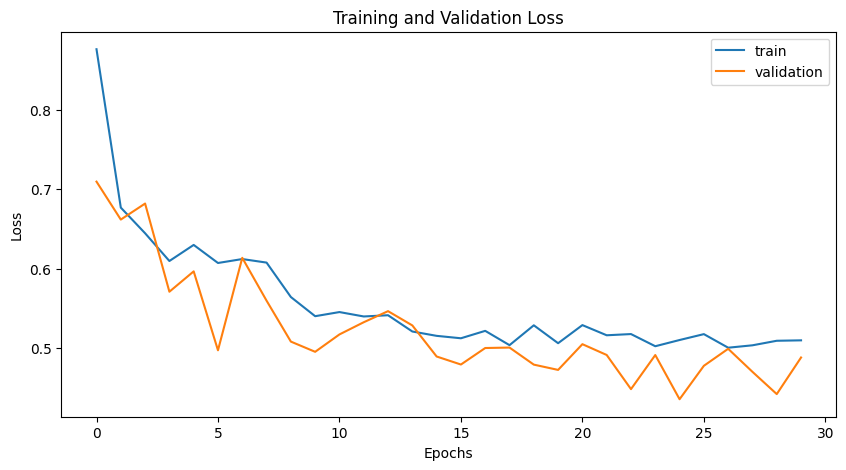

In [17]:
# Plot the training and validation loss
plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss")
plt.plot(training_loss, label="train")
plt.plot(validation_loss, label="validation")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [18]:
# Set the model to evaluation mode
model.eval()

# Store all the labels and probabilities
all_labels = []
all_probs = []

with torch.no_grad(): # No need to track the gradients
    for img, label in test_loader:
        img = img.to(device)
        label = label.to(device)

        outputs = model(img)
        # Apply softmax to output to get predicted probabilities
        probs = F.softmax(outputs, dim=1)[:, 1] # Probability of being a wolf
        
        # Store the labels and probabilities
        all_labels.extend(label.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

# Convert to numpy arrays
all_labels = np.array(all_labels)
all_probs = np.array(all_probs)

ROC AUC: 0.89


/tmp/ipykernel_4554/2730588579.py:25: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(sorted_tpr, sorted_fpr)


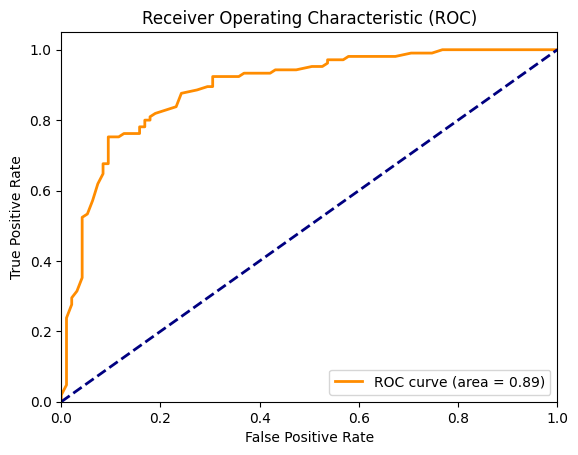

In [19]:
def compute_roc(labels, probs, num_thresholds=100):
    thresholds = np.linspace(0, 1, num_thresholds)
    tpr = np.zeros(num_thresholds)
    fpr = np.zeros(num_thresholds)

    # Loop through all thresholds and compute True Positive Rate and False Positive Rate
    for i, threshold in enumerate(thresholds):
        tp = np.sum((probs >= threshold) & (labels == 1))
        fp = np.sum((probs >= threshold) & (labels == 0))
        fn = np.sum((probs < threshold) & (labels == 1))
        tn = np.sum((probs < threshold) & (labels == 0))

        tpr[i] = tp / (tp + fn)
        fpr[i] = fp / (fp + tn)

    return fpr, tpr, thresholds

fpr, tpr, thresholds = compute_roc(all_labels, all_probs)

# Compute the area under the ROC curve to quantify the performance of the model
def compute_auc(fpr, tpr):
    sorted_indices = np.argsort(fpr)
    sorted_fpr = fpr[sorted_indices]
    sorted_tpr = tpr[sorted_indices]
    return np.trapz(sorted_tpr, sorted_fpr)

roc_auc = compute_auc(fpr, tpr)
print(f'ROC AUC: {roc_auc:.2f}')

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

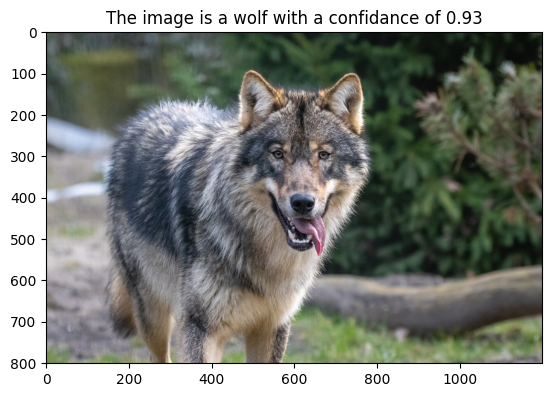

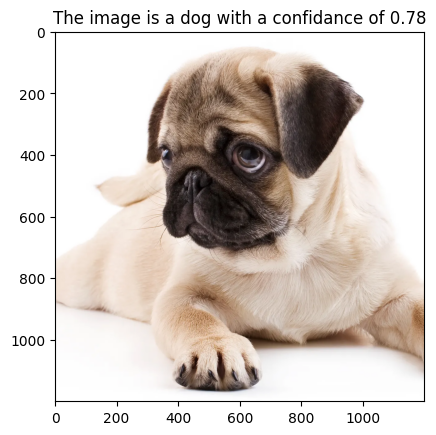

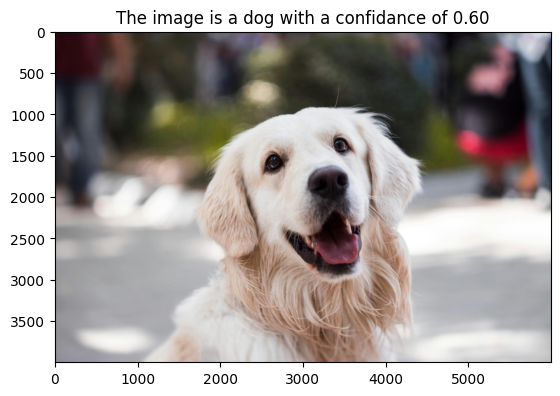

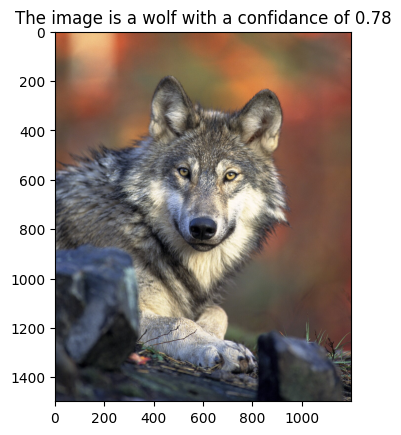

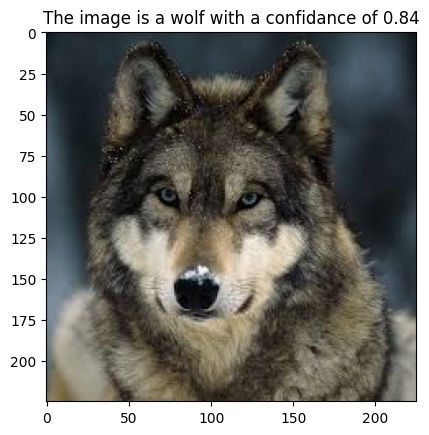

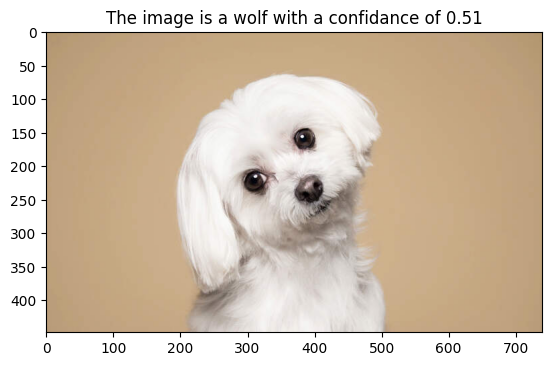

In [22]:
# Test the model on some images
path = "/home/adis/Desktop/DogsAndWolves/TestImage/"

for file in os.listdir(path):
    image = Image.open(path + file).convert("RGB")
    input_tensor = transform(image).unsqueeze(0).to(device)

    model_for_eval = CNN().to(device)
    model_for_eval.load_state_dict(torch.load('final_model_weights.pth'))
    model_for_eval.eval()

    with torch.no_grad():
        outputs = model_for_eval(input_tensor)
        #print(outputs)
        probs = F.softmax(outputs, dim=1)
        #print(probs)
        confidance, predicted_class = torch.max(probs, 1) # Returns the maximum value and index of the maximum value
    
    classes = ['dog', 'wolf']
    predicted_label = classes[predicted_class.item()]
    confidance_score = confidance.item()

    # Plot the images and predicted labels
    plt.imshow(image)
    plt.title(f'The image is a {predicted_label} with a confidance of {confidance_score:.2f}')
    plt.show()